# 월간 데이콘 법원 판결 예측 AI 경진대회
Dataset Info.
* ID : 사건 샘플 ID
* first_party : 사건의 첫 번째 당사자
* second_party : 사건의 두 번째 당사자
* facts : 사건 내용
* first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

**첫 번째 당사자의 승소 여부 예측하기**

# **1. Importing libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import nltk # 문장 토크나이저

# 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거
nltk.download('all')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
#
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 불용어(분석에 필요없는 토큰) 제거
    no_stops = [word for word in no_capitals if not word in stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

In [ ]:
# 데이터 늘린 걸로 한번해보자,,,ㅎㅎ
train = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/newtrain.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/test.csv')

In [ ]:
train = train[train['first_party_winner'] != 2]

In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
train

,first_party,second_party,facts,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1
...,...,...,...,...
3362,"Roman Catholic Diocese of Brooklyn, New York","Andrew M. Cuomo, Governor of New York",In an effort to curb rising infections of COVI...,1
3363,"Jose Santos Sanchez, et al.","Alejandro N. Mayorkas, Secretary of Homeland S...",Petitioners Jose Sanchez and his wife were cit...,0
3364,United States,Refugio Palomar-Santiago,"Refugio Palomar-Santiago, a Mexican national, ...",1
3365,Florida,Georgia,This is an ongoing case of original jurisdicti...,0


# **2. 파생변수 생성**

* first_party_win_percent	: 첫 번째 당사자가 승소할 확률. 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
* test에서는 first_party가 train의 first_party와 겹치는 경우에는 해당 사람의 승소할 확률을 반영함. 겹치지 않는 경우는 0.5로 반영함.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
train['sen_len'] = 0 # 문장 토큰화
train['word_len'] = 0 # 단어 토큰화

for i in range(len(train)):
  train.sen_len[i] = len(nltk.sent_tokenize(train.facts[i]))
  train.word_len[i] = len(word_tokenize(train.facts[i]))

train = train[['first_party', 'second_party', 'facts', 'sen_len', 'word_len', 'first_party_winner']]
train.head(10)

,first_party,second_party,facts,sen_len,word_len,first_party_winner
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1
5,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",11,210,1
6,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,7,264,1
7,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",6,205,1
8,"Ron Davis, Acting Warden",Hector Ayala,"Hector Ayala, a Hispanic man, was charged with...",12,478,1
9,Paul A. McDaniel,"Selma Cash Paty, et al.","Since its first state Constitution in 1796, Te...",7,144,1


In [ ]:
# winner: 해당 사건에서 승소한 사람
# frequency: winner의 총 등장 횟수
# win_percentage: 승소한 사람이 다른 사건에서도 승소할 확률

train['winner']=0
train['winner_frequency']=0
train['win_percentage']=0

for i in range(len(train)):
  if train['first_party_winner'][i]==1:
    train['winner'][i] = train['first_party'][i]
  else:
    train['winner'][i] = train['second_party'][i]

#for i in range(len(train)):
#  train['winner_frequency'][i] = len(train.loc[train['first_party'] == train['winner'][i]]) + len(train.loc[train['second_party'] == train['winner'][i]])
#  train['win_percentage'][i]= len(train.loc[train['winner'] == train['winner'][i]]) /(len(train.loc[train['first_party'] == train['winner'][i]]) + len(train.loc[train['second_party'] == train['winner'][i]]))

In [ ]:
# train['loser']=0
# train['lose_frequency']=0
# train['lose_percentage']=0

# for i in range(2477):
#   if train['first_party_winner'][i]==0:
#     train['loser'][i] = train['first_party'][i]
#   else:
#     train['loser'][i] = train['second_party'][i]

# for i in range(2477):
#   train['lose_frequency'][i] = len(train.loc[train['first_party'] == train['loser'][i]]) + len(train.loc[train['second_party'] == train['loser'][i]])
#   train['lose_percentage'][i]= len(train.loc[train['loser'] == train['loser'][i]]) /(len(train.loc[train['first_party'] == train['loser'][i]]) + len(train.loc[train['second_party'] == train['loser'][i]]))

In [ ]:
# first_party_frequency: first_party가 나타난 빈도
# first_party_win_percent: first_party가 승소할 확률 / 출현 빈도가 2이상일때만 반영함. 1일때는 0.5
train['first_party_win_percent'] = 0
train['first_party_frequency'] = 0

for i in range(len(train)):
  train['first_party_frequency'][i] = len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]])

  if (len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]])) > 1:
    train['first_party_win_percent'][i]= len(train.loc[train['winner'] == train['first_party'][i]]) /(len(train.loc[train['first_party'] == train['first_party'][i]]) + len(train.loc[train['second_party'] == train['first_party'][i]]))
  else:
    train['first_party_win_percent'][i] = 0.5

In [ ]:
train.tail(2)

,first_party,second_party,facts,sen_len,word_len,first_party_winner,winner,winner_frequency,win_percentage,first_party_win_percent,first_party_frequency
3365,Florida,Georgia,This is an ongoing case of original jurisdicti...,2,39,0,Georgia,0,0,0.62069,29
3366,PennEast Pipeline Co. LLC,"New Jersey, et al.","The Natural Gas Act (NGA), 15 U.S.C. §§ 717–71...",7,185,1,PennEast Pipeline Co. LLC,0,0,0.50000,1


In [ ]:
#train=train.drop(['winner',	'winner_frequency',	'win_percentage',	'loser',	'lose_frequency',	'lose_percentage'],axis=1)
train=train.drop(['winner',	'winner_frequency',	'win_percentage'],axis=1)

In [ ]:
train

,first_party,second_party,facts,sen_len,word_len,first_party_winner,first_party_win_percent,first_party_frequency
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1,0.500000,1
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0,0.500000,1
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1,0.500000,1
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0,0.500000,1
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1,0.500000,1
...,...,...,...,...,...,...,...,...
3362,"Roman Catholic Diocese of Brooklyn, New York","Andrew M. Cuomo, Governor of New York",In an effort to curb rising infections of COVI...,7,192,1,0.500000,1
3363,"Jose Santos Sanchez, et al.","Alejandro N. Mayorkas, Secretary of Homeland S...",Petitioners Jose Sanchez and his wife were cit...,7,235,0,0.500000,1
3364,United States,Refugio Palomar-Santiago,"Refugio Palomar-Santiago, a Mexican national, ...",17,384,1,0.584942,518
3365,Florida,Georgia,This is an ongoing case of original jurisdicti...,2,39,0,0.620690,29


In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## 어간추출 Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## 표제어 추출 Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    # 데이터 클리닝
    df["fact_processing"] = df["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

    # TF-IDF -- 파라미터 조정 필요?
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [ ]:
train.isnull().sum()

first_party                1
second_party               1
facts                      0
sen_len                    0
word_len                   0
first_party_winner         0
first_party_win_percent    0
first_party_frequency      0
dtype: int64

In [ ]:
train = train.dropna(axis=0)

In [ ]:
# 벡터화 함수 적용
X = get_vector(vectorizer, train, True)
Y = train["first_party_winner"]
X_train = np.asarray(X) # np.array 활용 및 적용
Y_train = np.asarray(Y)

In [ ]:
X.shape

(3365, 62520)

In [ ]:
Y.shape

(3365,)

In [ ]:
X_train.shape

(3365, 62520)

In [ ]:
Y.value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       0
2       1
3       0
4       1
       ..
3362    1
3363    0
3364    1
3365    0
3366    1
Name: first_party_winner, Length: 3365, dtype: int64>

In [ ]:
x_train, x_test, yy_train, yy_test = train_test_split(X_train,Y_train, test_size=0.25)

#**Define Model & Train**

로지스틱 회귀

In [ ]:
#logistic
model = LogisticRegression()

#X_train = np.asarray(x_train) # np.array 활용 및 적용
#Y_train = np.asarray(yy_train)
#X_test = np.asarray(x_test) # np.array 활용 및 적용
#Y_test = np.asarray(yy_test)

model = LogisticRegression()
model.fit(x_train, yy_train)

LogisticRegression()

In [ ]:
model.score(x_test,yy_test)

0.6413301662707839

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

랜덤포레스트

In [ ]:
#logistic
model = RandomForestClassifier()
model.fit(x_train, yy_train)

RandomForestClassifier()

In [ ]:
model.score(x_train,yy_train)

1.0

In [ ]:
model.score(x_test,yy_test)

0.6543942992874109

KNeighborsClassifier(n_neighbors=3)

In [ ]:
model = knn=KNeighborsClassifier(n_neighbors=7)
model.fit(x_train, yy_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
model.score(x_test,yy_test)

0.6175771971496437

XGBClassifier()

In [ ]:
model = XGBClassifier()
model.fit(x_train, yy_train)

In [ ]:
model.score(X_test,Y_test)

CATBOOST

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
Y.value_counts()

1    2194
0    1171
Name: first_party_winner, dtype: int64

In [ ]:
counts = list(Y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.3479940564635958, 0.6520059435364042]


In [ ]:
model = CatBoostClassifier(random_seed=42,class_weights=class_weight, verbose=0)
model.fit(x_train, yy_train)

In [ ]:
model.score(x_test,yy_test)

0.6555819477434679

#**변수 추가를 어떻게 해야하지,,,,?**

In [ ]:
train

,first_party,second_party,facts,sen_len,word_len,first_party_winner,first_party_win_percent,first_party_frequency,fact_processing
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",7,201,1,0.5,1,june 27 1962 phil st amant candidate public of...
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,7,219,0,0.5,1,ramon nelson riding bike suffered lethal blow ...
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,8,191,1,0.5,1,alabama state court convicted billy joe magwoo...
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,3,59,0,0.5,1,victor linkletter convicted state court eviden...
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",9,200,1,0.5,1,april 24 1953 selma alabama intruder broke apa...
...,...,...,...,...,...,...,...,...,...
3362,"Roman Catholic Diocese of Brooklyn, New York","Andrew M. Cuomo, Governor of New York",In an effort to curb rising infections of COVI...,7,192,1,0.0,0,effort curb rising infection covid19 new york ...
3363,"Jose Santos Sanchez, et al.","Alejandro N. Mayorkas, Secretary of Homeland S...",Petitioners Jose Sanchez and his wife were cit...,7,235,0,0.0,0,petitioner jose sanchez wife citizen el salvad...
3364,United States,Refugio Palomar-Santiago,"Refugio Palomar-Santiago, a Mexican national, ...",17,384,1,0.0,0,refugio palomarsantiago mexican national grant...
3365,Florida,Georgia,This is an ongoing case of original jurisdicti...,2,39,0,0.0,0,ongoing case original jurisdiction fact explai...


(array([8.500e+01, 1.000e+00, 7.000e+00, 2.000e+00, 8.000e+00, 1.900e+01,
        3.900e+01, 0.000e+00, 4.600e+01, 2.000e+01, 2.565e+03, 2.620e+02,
        2.000e+01, 3.600e+01, 5.000e+00, 1.100e+01, 1.500e+01, 1.300e+01,
        0.000e+00, 2.130e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

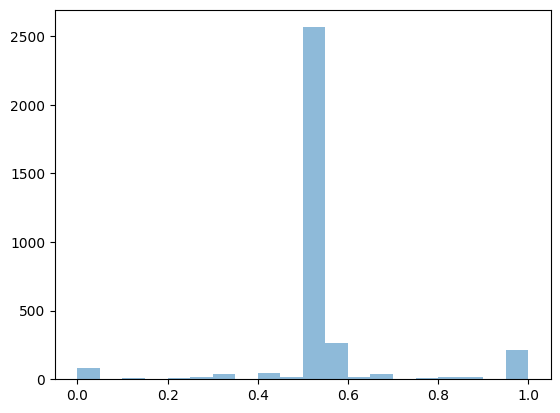

In [ ]:
plt.hist(train['first_party_win_percent'], bins = 20, alpha=0.5)

In [ ]:
train[train['first_party_frequency']>40]['first_party']

18      United States
26      United States
31      United States
60      United States
84      United States
            ...      
2445    United States
2456    United States
2464    United States
2471    United States
2472    United States
Name: first_party, Length: 161, dtype: object

In [ ]:
train.describe()

,sen_len,word_len,first_party_winner,first_party_win_percent,first_party_frequency
count,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000
mean,7.549777,196.366122,0.652006,0.360480,25.228826
std,3.559036,95.411875,0.476405,0.243148,107.993206
min,1.000000,3.000000,0.000000,0.000000,0.000000
25%,5.000000,133.000000,0.000000,0.000000,0.000000
50%,7.000000,185.000000,1.000000,0.500000,1.000000
75%,9.000000,246.000000,1.000000,0.500000,1.000000
max,46.000000,1088.000000,1.000000,1.000000,518.000000


In [ ]:
import seaborn as sns

In [ ]:
len(train)

3367

In [ ]:
train['first_party_win_percent'][0] < 0.2

False

In [ ]:
train['승률범주형분류'] = 0

for i in range(len(train)):
  if train['first_party_win_percent'][i] < 0.2:
    train['승률범주형분류'][i] = 'lose'
  elif train['first_party_win_percent'][i]>= 0.8:
    train['승률범주형분류'][i] = 'win'
  else:
    train['승률범주형분류'][i] = '미정'

In [ ]:
train['승률범주형분류'].value_counts()

미정      3031
win      241
lose      95
Name: 승률범주형분류, dtype: int64

In [ ]:
train = train.dropna(axis=0)

In [ ]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    # 데이터 클리닝
    df["fact_processing"] = df["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

    # TF-IDF -- 파라미터 조정 필요?
    if train_mode:
        X_facts = vectorizer.fit_transform(df['fact_processing'])
    else:
        X_facts = vectorizer.transform(df['fact_processing'])

    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X_parsed_winlose= vectorizer.transform(df['승률범주형분류'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense(), X_parsed_winlose.todense()], axis=1)
    return X

In [ ]:
X = get_vector(vectorizer, train, True)
Y = train["first_party_winner"]


In [ ]:
X_train = np.asarray(X) # np.array 활용 및 적용
Y_train = np.asarray(Y)

In [ ]:
x_train, x_test, yy_train, yy_test = train_test_split(X_train,Y_train, test_size=0.25)

In [ ]:
#logistic
model = LogisticRegression()

#X_train = np.asarray(x_train) # np.array 활용 및 적용
#Y_train = np.asarray(yy_train)
#X_test = np.asarray(x_test) # np.array 활용 및 적용
#Y_test = np.asarray(yy_test)

model = LogisticRegression()
model.fit(x_train, yy_train)

LogisticRegression()

In [ ]:
model.score(x_test,yy_test)

0.7042755344418052

In [ ]:
counts = list(Y.value_counts())
class_weight = [counts[1]/sum(counts), counts[0]/sum(counts)]
print("weight :", class_weight)

weight : [0.3479940564635958, 0.6520059435364042]


In [ ]:
model = CatBoostClassifier(random_seed=42,class_weights=class_weight, verbose=0)
model.fit(x_train, yy_train)

In [ ]:
model.score(x_test,yy_test)

0.6959619952494062

#**submission**

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/sample_submission.csv')

In [ ]:
X_test = np.asarray(X_test)
pred = model.predict(X_test)

In [ ]:
submit['first_party_winner'] = pred
submit.to_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/code/submission/baseline_submit_logistic_newdata.csv', index=False)
print('Done')

Done
